<a href="https://colab.research.google.com/github/frag30041997/jupyter-one/blob/Cours-Data-Analyst/TP_final_ML_rainbow6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP data engineering R6
Le but est de determiner les facteurs clé de la victoire dans une partie de rainbow 6 siege

In [198]:
"""
Départ, avec tout les imports et les fonctions + initialisation des DF
"""

import pandas as pd
import seaborn as sns; sns.set
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DTC

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder as LE

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#fonction pour obtenir l'accuraty avec les predictions et les targets
def accuracy(preds,target):
  return (preds==target).sum()/len(target)

#focntion affichage de confusion matrix
def show_cm(confusion_matrix, labels):
    df_cm = pd.DataFrame(confusion_matrix, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

#fonction qui reécrit une colonne pour la refaire en int 
def sci_to_int(feature):
  iplist = []
  for i in range(len(feature)):
    iplist.append(int(feature[i]))
  return iplist

# prend une colonne du dataframe ex: df.colonne
# et créé un dictionnaire de chaque valeurs distinctes
def dico_unique(colonne):
  uniques = colonne.unique()
  dictionnaire = dict()
  for i in range(colonne.nunique()) :
    dictionnaire[i]=uniques[i]
  return dictionnaire

#création rapide de pipeline
def pipeline(X_train_data, X_test_data, y_train_data, y_test_data,model, param_grid):
    
    gridSearch = GridSearchCV(estimator=model,param_grid=param_grid, cv=5, scoring='accuracy')
    modelTrain = gridSearch.fit(X_train_data, y_train_data)
    pred = modelTrain.predict(X_test_data)
    
    return modelTrain, pred

# Afficher la courbe ROC
def show_roc(model,X_test,Y_test) :
    # Afficher la courbe roc 
    metrics.plot_roc_curve(model, X_test, Y_test)
    
    #Style du graphe
    fig = mp.pyplot.gcf()
    plt.title('Courbe ROC')
    fig.set_size_inches(20,6)
    
    plt.show()

def show_featuresImportance(X_train,feature_importances) :
    
    # On crer un nouveau dataframe
    d = pd.DataFrame()
    # On ajoute la liste de nos features
    d['features'] = X_train.columns
    # On ajoute la liste des feature_importances
    d['pouvoir_predictif'] = feature_importances
    # Mettre nos features importances en pourcentage
    d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
    # Trie des valeurs du plus important au moins important
    d = d.sort_values(by='pouvoir_predictif', ascending=False)
    
    # Affiche le graphe
    sns.barplot(d['pouvoir_predictif'], d['features'])
    
    #Style du graphe
    fig = mp.pyplot.gcf()
    plt.title('Pouvoir predictif des features')
    fig.set_size_inches(20,6)

#on part d'un fichier réduit pour raisons pratiques (importation drive impossible sinon)
df_rainb = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/S5_operators.csv',sep=';', encoding="ISO-8859-1",engine='python')
df_rainb.shape

(509692, 12)

#panda profiler

In [199]:
"""
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport
"""

'\n!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip\nfrom pandas_profiling import ProfileReport\n'

In [200]:
"""
profile = ProfileReport(df_rainb, title="rainbow", html={'style' : {'full_width': True}})
"""

'\nprofile = ProfileReport(df_rainb, title="rainbow", html={\'style\' : {\'full_width\': True}})\n'

#profile_report

In [201]:
"""
profile.to_notebook_iframe()
"""

'\nprofile.to_notebook_iframe()\n'

#Preprocessing

Le dataset est trop volumineux mais on ne peut pas retirer des données au hasard car on veux des donnés sur plusieurs dates, il va falloir commencer par un gros travail de preprocessing qui définira grandement le rendu par effet papillon.
- version minimale trouvée avec 510 000 lignes

#Phase 2 (transfo data)

In [202]:
#on observe les donnés pour se faire une première idée
df_rainb.head(5)

,platform,dateid,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,CLAYMORE,6,6,6,8
1,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,STUN GRENADE,4,2,6,8
2,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,CLAYMORE,37,40,49,70
3,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,STUN GRENADE,17,24,31,41
4,PC,20170210,Bronze,Attacker,G.E.O.-JACKAL,C7E,ITA12S,BREACH CHARGE,74,123,127,174


In [203]:
#check basique des datas
df_rainb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509692 entries, 0 to 509691
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   platform         509692 non-null  object
 1   dateid           509692 non-null  int64 
 2   skillrank        509692 non-null  object
 3   role             509692 non-null  object
 4   operator         509692 non-null  object
 5   primaryweapon    509692 non-null  object
 6   secondaryweapon  509692 non-null  object
 7   secondarygadget  509692 non-null  object
 8   nbwins           509692 non-null  int64 
 9   nbkills          509692 non-null  int64 
 10  nbdeaths         509692 non-null  int64 
 11  nbpicks          509692 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 46.7+ MB


In [204]:
#ajout de colonnes

#ratio victoire de manche, indicateur plus précis que le gamewin
df_rainb['win_ratio'] = pd.to_numeric(df_rainb['nbwins']) / pd.to_numeric(df_rainb['nbpicks'])

#ratio morts/tués, indicateur basique de performance en jeu
df_rainb['kd_ratio'] = pd.to_numeric(df_rainb['nbkills']) / pd.to_numeric(df_rainb['nbdeaths'])

#création du gamewin boolean
#si plus de la moitié des manches sont gagnées, la partie est gagnée sinon non
roundwin = []
for i in df_rainb.nbpicks :
  if df_rainb.nbwins[i] > df_rainb.nbpicks[i]/2:
    roundwin.append(1)
  else :
    roundwin.append(0)

df_rainb['dateid'] = pd.to_datetime(df_rainb['dateid'],format='%Y%m%d')

jour = []
for i in range(len(df_rainb.dateid)) :
  #print(i)
  jour.append(df_rainb.dateid[i].day)
df_rainb['day'] = jour

mois = []
for i in range(len(df_rainb.dateid)) :
  mois.append(df_rainb.dateid[i].month)
df_rainb['month'] = mois

annee = []
for i in range(len(df_rainb.dateid)) :
  annee.append(df_rainb.dateid[i].year)
df_rainb['year'] = annee

#on ajoute la variable au dataset
df_rainb['gamewin'] = roundwin


In [205]:
labenc = LE() #initialisation labelencoder

#df['col'] = df['col'].apply(lambda x: str(x))

#uniformisation des datas (+ création des dictionnaires)

dico_platform = dico_unique(df_rainb.platform.apply(lambda x: str(x)))
df_rainb['platform'] = labenc.fit_transform(df_rainb['platform'])

dico_skillrank = dico_unique(df_rainb.skillrank.apply(lambda x: str(x)))
df_rainb['skillrank'] = labenc.fit_transform(df_rainb['skillrank'])

dico_role = dico_unique(df_rainb.role.apply(lambda x: str(x)))
df_rainb['role'] = labenc.fit_transform(df_rainb['role'])

dico_operator = dico_unique(df_rainb.operator.apply(lambda x: str(x)))
df_rainb['operator'] = labenc.fit_transform(df_rainb['operator'])

dico_primaryweapon = dico_unique(df_rainb.primaryweapon.apply(lambda x: str(x)))
df_rainb['primaryweapon'] = labenc.fit_transform(df_rainb['primaryweapon'])

dico_secondaryweapon = dico_unique(df_rainb.secondaryweapon.apply(lambda x: str(x)))
df_rainb['secondaryweapon'] = labenc.fit_transform(df_rainb['secondaryweapon'])

dico_secondarygadget = dico_unique(df_rainb.secondarygadget.apply(lambda x: str(x)))
df_rainb['secondarygadget'] = labenc.fit_transform(df_rainb['secondarygadget'])

df_rainb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509692 entries, 0 to 509691
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   platform         509692 non-null  int64         
 1   dateid           509692 non-null  datetime64[ns]
 2   skillrank        509692 non-null  int64         
 3   role             509692 non-null  int64         
 4   operator         509692 non-null  int64         
 5   primaryweapon    509692 non-null  int64         
 6   secondaryweapon  509692 non-null  int64         
 7   secondarygadget  509692 non-null  int64         
 8   nbwins           509692 non-null  int64         
 9   nbkills          509692 non-null  int64         
 10  nbdeaths         509692 non-null  int64         
 11  nbpicks          509692 non-null  int64         
 12  win_ratio        509692 non-null  float64       
 13  kd_ratio         505093 non-null  float64       
 14  day              509

In [206]:
df_rainb.head(5)

,platform,dateid,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks,win_ratio,kd_ratio,day,month,year,gamewin
0,0,2017-02-10,0,0,0,21,13,2,6,6,6,8,0.750000,1.000000,10,2,2017,0
1,0,2017-02-10,0,0,0,21,13,8,4,2,6,8,0.500000,0.333333,10,2,2017,0
2,0,2017-02-10,0,0,0,32,13,2,37,40,49,70,0.528571,0.816327,10,2,2017,0
3,0,2017-02-10,0,0,0,32,13,8,17,24,31,41,0.414634,0.774194,10,2,2017,0
4,0,2017-02-10,0,0,2,9,4,1,74,123,127,174,0.425287,0.968504,10,2,2017,1


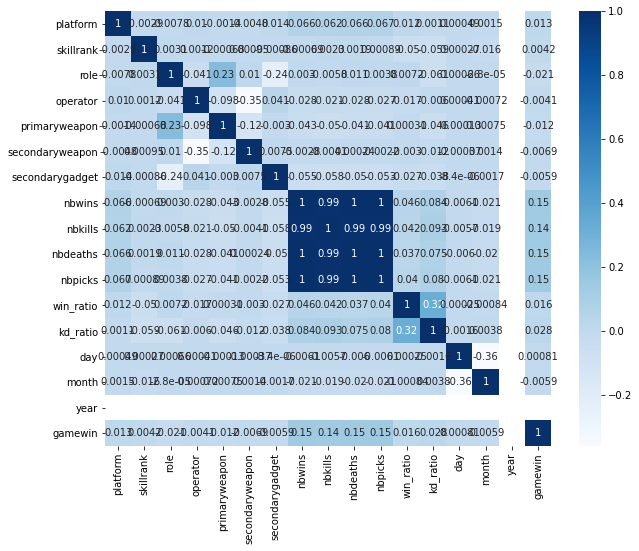

In [207]:
plt.figure(figsize = (10,8))
heat = sns.heatmap(df_rainb.corr(),annot=True,cmap="Blues")

In [208]:
print(df_rainb.dateid[1].day)
print(df_rainb.dateid[1].month)

10
2


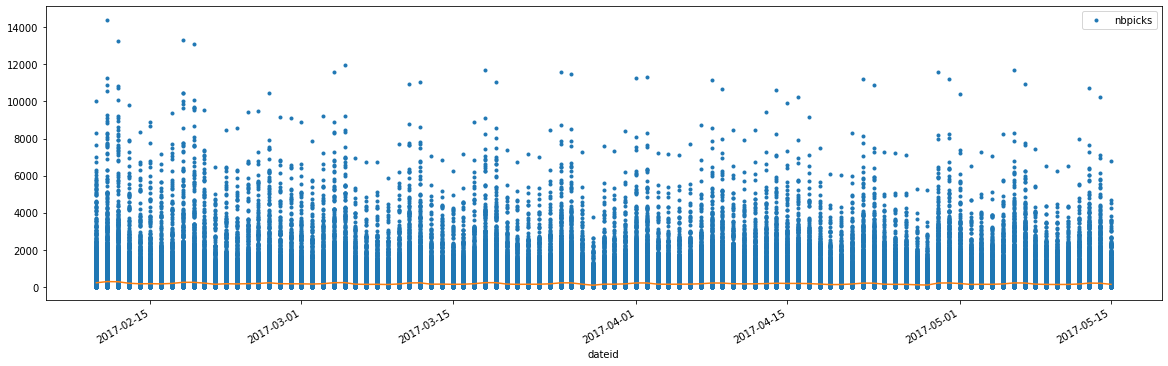

In [209]:
df_rainb.plot(x='dateid', y='nbpicks', style='.')
df_rainb.groupby('dateid')['nbpicks'].mean().plot(x='dateid', y='nbpicks')#esquive de piege
fig = mp.pyplot.gcf() #a importer pour faire des modifs de style
fig.set_size_inches(20,6)

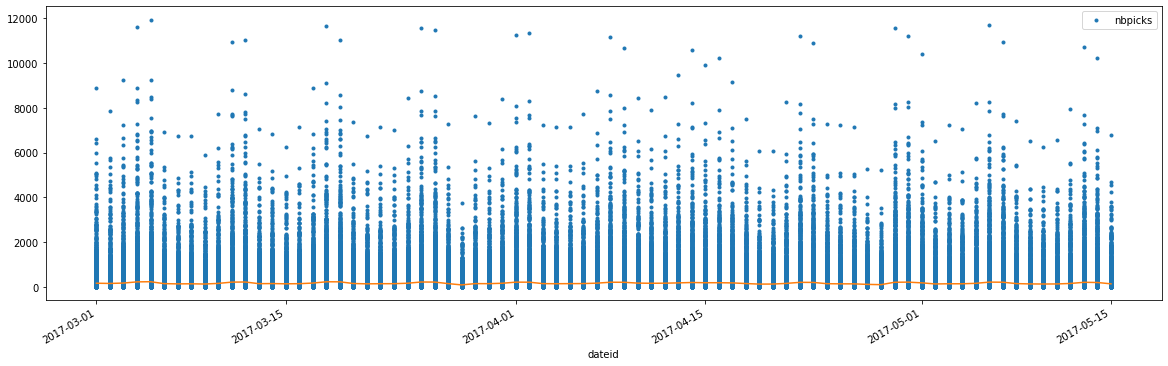

In [210]:
df_rainb_mars = df_rainb.query(" dateid >= '2017-03-01' and dateid < '2020-04-01 00:00'")
df_rainb_mars.plot(x='dateid', y='nbpicks', style='.')
df_rainb_mars.groupby('dateid')['nbpicks'].mean().plot(x='dateid', y='nbpicks')#esquive de piege
fig = mp.pyplot.gcf() #a importer pour faire des modifs de style
fig.set_size_inches(20,6)

In [211]:
"""df_rainb_jour = df_rainb.query("dateid == '2017-03-01'")


#df_rainb_mars.plot(x='operator', y='nbwins', style='.')
#df_rainb_mars.groupby('dateid')['nbpicks'].mean().plot(x='dateid', y='nbpicks')#esquive de piege
fig = mp.pyplot.gcf() #a importer pour faire des modifs de style
fig.set_size_inches(20,6)
Data = {'operateur': dico_operator.keys,
        'nbwins': df_rainb_jour.nbwins
       }



df = pd.DataFrame(Data,columns=['operateur','nbwins'])
df.plot(x ='operateur', y='nbwins', kind = 'bar')
plt.title("Diagramme du nombre de manches gagnés par opérateur")
plt.show()
"""

'df_rainb_jour = df_rainb.query("dateid == \'2017-03-01\'")\n\n\n#df_rainb_mars.plot(x=\'operator\', y=\'nbwins\', style=\'.\')\n#df_rainb_mars.groupby(\'dateid\')[\'nbpicks\'].mean().plot(x=\'dateid\', y=\'nbpicks\')#esquive de piege\nfig = mp.pyplot.gcf() #a importer pour faire des modifs de style\nfig.set_size_inches(20,6)\nData = {\'operateur\': dico_operator.keys,\n        \'nbwins\': df_rainb_jour.nbwins\n       }\n\n\n\ndf = pd.DataFrame(Data,columns=[\'operateur\',\'nbwins\'])\ndf.plot(x =\'operateur\', y=\'nbwins\', kind = \'bar\')\nplt.title("Diagramme du nombre de manches gagnés par opérateur")\nplt.show()\n'

#Premier Bilan

d'après la heatmap de correlation, il n'y a pas de facteurs qui sortent du lot par rapport à leurs corrélation avec avec la target, ce qui est finamelement tout à fait normal, cela signifie qu'il n'y a pas de gamebreaker, càd qu'il n'y a pas d'éléments qui permettent d'augmenter ou de réduire de manière radicale les chances de remporter une partie.

nous allons nous enfoncer plus profondement dans les donnés et voir si on peux agir à une echelle plus réduite.

In [212]:
#sns.catplot(x="platform", y="skillrank", kind='bar' ,data=df_rainb)

In [213]:
#sns.pairplot(df_rainb,hue='platform',diag_kind='kde',height=2,corner=True)

In [214]:
df_rainb.describe()

,platform,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks,win_ratio,kd_ratio,day,month,year,gamewin
count,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,509692.000000,5.050930e+05,509692.000000,509692.000000,509692.0,509692.000000
mean,1.051784,3.057719,0.496749,17.570519,23.130430,7.514632,3.981171,85.802636,118.338008,118.925349,168.611036,0.484261,inf,15.161778,3.431141,2017.0,0.215615
std,0.800911,2.072877,0.499990,10.389314,12.876091,4.274116,2.633721,248.085908,362.400237,339.997438,480.191839,0.215873,NaN,8.366284,0.978113,0.0,0.411248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.000000,2.000000,2017.0,0.000000
25%,0.000000,1.000000,0.000000,7.000000,13.000000,5.000000,2.000000,2.000000,3.000000,4.000000,5.000000,0.410256,5.333333e-01,8.000000,3.000000,2017.0,0.000000
50%,1.000000,3.000000,0.000000,19.000000,22.000000,8.000000,4.000000,11.000000,13.000000,16.000000,22.000000,0.500000,8.571429e-01,15.000000,3.000000,2017.0,0.000000
75%,2.000000,5.000000,1.000000,27.000000,35.000000,11.000000,6.000000,56.000000,72.000000,81.000000,114.000000,0.555556,1.086957e+00,22.000000,4.000000,2017.0,0.000000
max,2.000000,6.000000,1.000000,34.000000,45.000000,15.000000,8.000000,7752.000000,12973.000000,10242.000000,14410.000000,1.000000,inf,31.000000,5.000000,2017.0,1.000000


#Premier Run

##isolation target

In [215]:
df_rainb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509692 entries, 0 to 509691
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   platform         509692 non-null  int64         
 1   dateid           509692 non-null  datetime64[ns]
 2   skillrank        509692 non-null  int64         
 3   role             509692 non-null  int64         
 4   operator         509692 non-null  int64         
 5   primaryweapon    509692 non-null  int64         
 6   secondaryweapon  509692 non-null  int64         
 7   secondarygadget  509692 non-null  int64         
 8   nbwins           509692 non-null  int64         
 9   nbkills          509692 non-null  int64         
 10  nbdeaths         509692 non-null  int64         
 11  nbpicks          509692 non-null  int64         
 12  win_ratio        509692 non-null  float64       
 13  kd_ratio         505093 non-null  float64       
 14  day              509

In [216]:
#pour eviter erreur ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
df_rainb['win_ratio'].astype('category')
df_rainb['kd_ratio'].astype('category')


y =  df_rainb.gamewin
x = df_rainb.drop(['gamewin','dateid','win_ratio','kd_ratio'],axis='columns')


x.shape,y.shape

((509692, 14), (509692,))

##split

In [217]:

splits = train_test_split(x,y, train_size=0.60,stratify=y,random_state=50) #separe le dataset en deux parties 1 pour entrainement a la prediction et l'autre pour le test operationnel
                                              # stratify important car permet de récolter des reponses a comparer auxprediction de manière a tester le plus de cas possibles ( empeche de prendre ici que 1,2 ou 3 en réponse)
x_train = splits[0]
x_test = splits[1]
y_train = splits[2]
y_test = splits[3]



In [218]:
#Pipeline
"""
pipeline_details = [('PCA', PCA(random_state=1337)),
                    ('RF', RF())]
pipeline = Pipeline(steps=pipeline_details)

#GridSearchCV
hyperparameters = {}
hyperparameters['PCA__n_components'] = [i for i in range(1, x_train.shape[1]+1,3)]
hyperparameters['RF__n_estimators']  = [i for i in range(70,150+1,20)]
print(hyperparameters)
"""

"\npipeline_details = [('PCA', PCA(random_state=1337)),\n                    ('RF', RF())]\npipeline = Pipeline(steps=pipeline_details)\n\n#GridSearchCV\nhyperparameters = {}\nhyperparameters['PCA__n_components'] = [i for i in range(1, x_train.shape[1]+1,3)]\nhyperparameters['RF__n_estimators']  = [i for i in range(70,150+1,20)]\nprint(hyperparameters)\n"

##Train

In [219]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509692 entries, 0 to 509691
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   platform         509692 non-null  int64
 1   skillrank        509692 non-null  int64
 2   role             509692 non-null  int64
 3   operator         509692 non-null  int64
 4   primaryweapon    509692 non-null  int64
 5   secondaryweapon  509692 non-null  int64
 6   secondarygadget  509692 non-null  int64
 7   nbwins           509692 non-null  int64
 8   nbkills          509692 non-null  int64
 9   nbdeaths         509692 non-null  int64
 10  nbpicks          509692 non-null  int64
 11  day              509692 non-null  int64
 12  month            509692 non-null  int64
 13  year             509692 non-null  int64
dtypes: int64(14)
memory usage: 54.4 MB


In [220]:
#algorithme KNN #from sklearn.neighbors import KNeighborsClassifier as KNN
#initialize
knn = KNN(n_neighbors=3)

knn.fit(x_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

##test

In [221]:
#au cas ou ça peut servir plus tard
pred = knn.predict(x_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

##metrics

#KNN

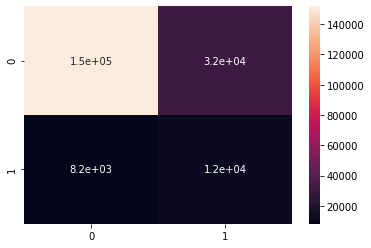

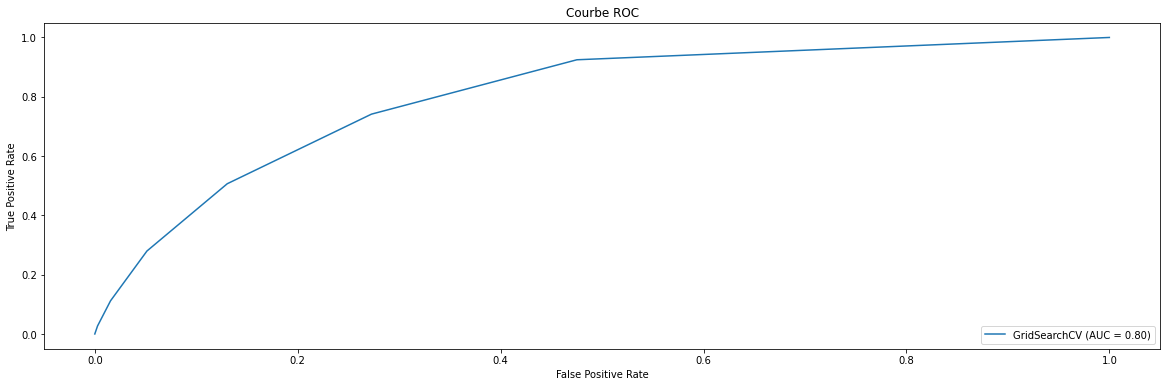

0.8005820512401289
{'algorithm': 'auto', 'leaf_size': 7, 'n_neighbors': 6}


In [223]:
classes = y.astype('category').cat.categories.tolist()
param_grid = {
              'n_neighbors':[2, 6],
              'leaf_size':[3,7],
              'algorithm':['auto']
             }

model = KNN()
model, y_pred = pipeline(x_train, x_test, y_train, y_test, model,param_grid)

cm_train = confusion_matrix(y_pred, y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, x_test, y_test)

print(model.best_score_)
print(model.best_params_)

#Random Forest

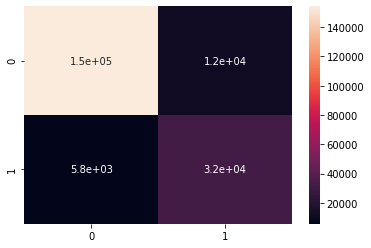

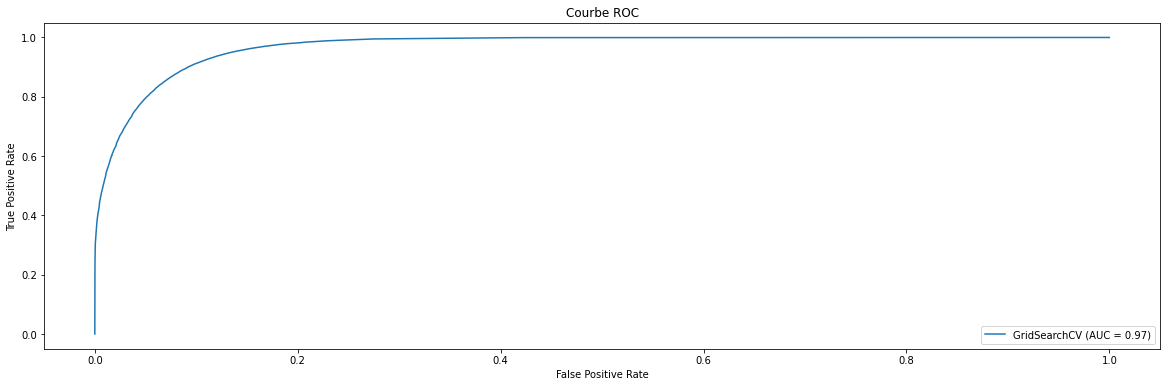

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.9099520952209668
{'min_samples_split': 5, 'n_estimators': 12, 'random_state': 100}


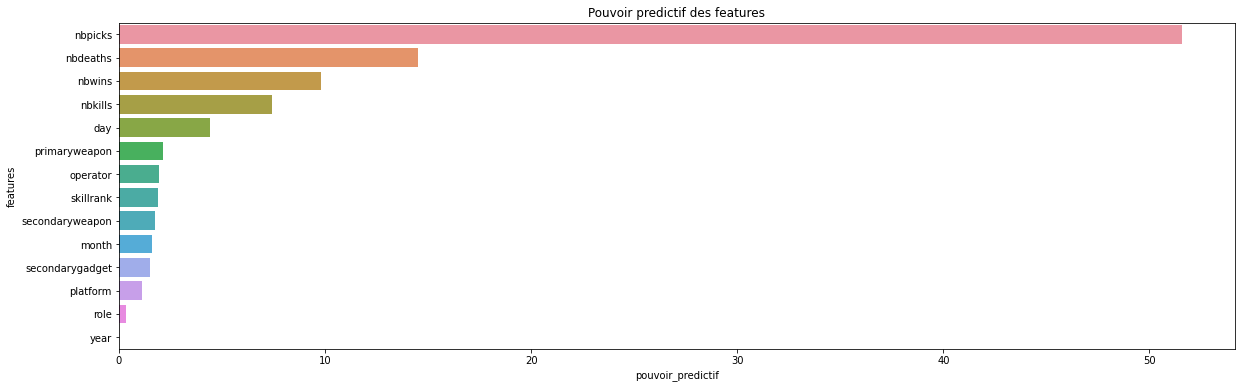

In [229]:
classes = y.astype('category').cat.categories.tolist()
param_grid = {
              'random_state':[100, 200],
              'n_estimators':[8,12],
              'min_samples_split':[3,5]
             }

model = RF()
model, y_pred = pipeline(x_train, x_test, y_train, y_test, model,param_grid)

cm_train = confusion_matrix(y_pred, y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, x_test, y_test)

show_featuresImportance(x_train,model.best_estimator_.feature_importances_)


print(model.best_score_)
print(model.best_params_)

#DTC

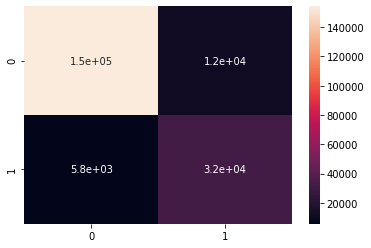

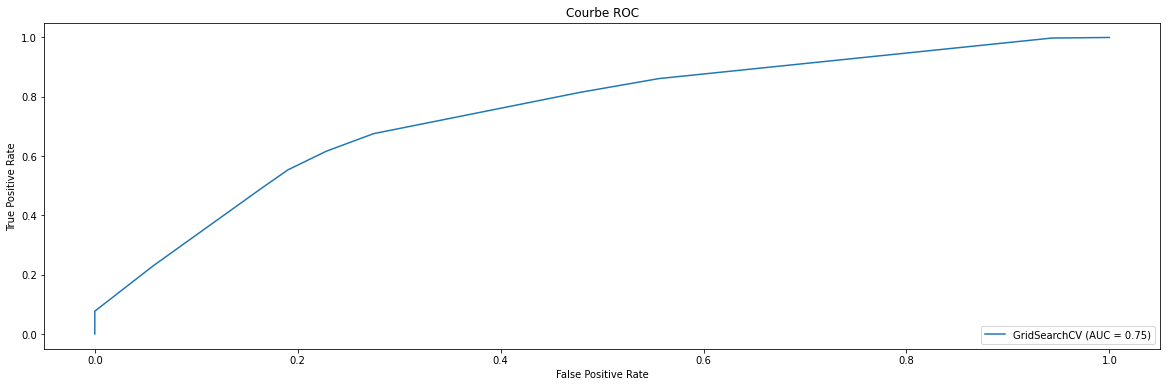

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.814456452430391
{'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 10}


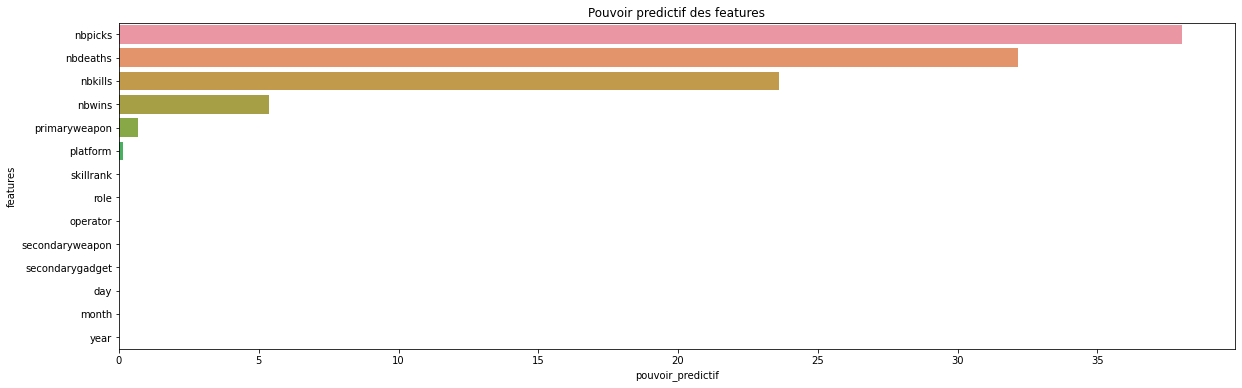

In [231]:
param_grid = {
              'max_depth':[10,15],
              'max_features':['auto'],
              'max_leaf_nodes':[5,10,20]
             }

model = DTC()
model, Y_pred = pipeline(x_train, x_test, y_train, y_test, model,param_grid)

cm_train = confusion_matrix(y_pred, y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, x_test, y_test)

show_featuresImportance(x_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

#Fin du premier run
#Bilan 2
blabla
